# Response matrices

In [1]:
import at
import numpy as np
import math
from pathlib import Path
from importlib.resources import files, as_file
from timeit import timeit

In [2]:
with as_file(files("machine_data") / "hmba.mat") as path:
    hmba_lattice = at.load_lattice(path)

In [3]:
for sx in hmba_lattice.select(at.Sextupole):
    sx.KickAngle=[0,0]
hmba_lattice.enable_6d()

In [4]:
ring = hmba_lattice.repeat(8)

A {py:class}`.ResponseMatrix` object defines a general-purpose response matrix, based
on a {py:class}`.VariableList` of attributes which will be independently varied, and an
{py:class}`.ObservableList` of attributes which will be recorded for each
variable step.

{py:class}`.ResponseMatrix` objects can be combined with the "+" operator to define
combined responses. This concatenates the variables and the observables.

This module also defines two commonly used response matrices:
{py:class}`.OrbitResponseMatrix` for circular machines and
{py:class}`.TrajectoryResponseMatrix` for beam lines. Other matrices can be easily
defined by providing the desired Observables and Variables to the
{py:class}`.ResponseMatrix` base class.

## Instantiation of an orbit response matrix

The simplest orbit response matrix can be instantiated with:

In [5]:
resp_v = at.OrbitResponseMatrix(ring, "v")

By default, the observables are all the {py:class}`.Monitor` elements, and the
variables are all the elements having a *KickAngle* attribute. This is equivalent to:
```python
resp_v = at.OrbitResponseMatrix(ring, "v", bpmrefs = at.Monitor,
                             steerrefs = at.checkattr("KickAngle"))
```
If correction is desired, the variable elements must have the *KickAngle* attribute
used for correction. It's available for all magnets, though not present by default
except in {py:class}`.Corrector` magnets. For other magnets, the attribute should be
explicitly created.

There are options in {py:class}`.OrbitResponseMatrix`to include the RF frequency in the
variable list, and the sum of correction angles in the list of observables:

In [6]:
resp_h = at.OrbitResponseMatrix(ring, "h", cavrefs=at.RFCavity, steersum=True)
print(resp_h.shape)

(81, 49)


A combined horizontal+vertical response matrix can be obtained with:
```python
resp_hv = resp_h + resp_v
```

## Matrix Building

The response matrix may be built by three methods:

1. {py:meth}`~.ResponseMatrix.build_tracking` computes the matrix using tracking.
2. {py:meth}`~.OrbitResponseMatrix.build_analytical` analytically computes the matrix using formulas
   from [^1].
3. {py:meth}`~.ResponseMatrix.load` loads data from a file containing previously
   saved values or experimentally measured values

[^1]: A. Franchi, S.M. Liuzzo, Z, Marti, _"Analytic formulas for the rapid evaluation of the orbit
response matrix and chromatic functions from lattice parameters in circular accelerators"_,
arXiv:1711.06589 [physics.acc-ph]

In [7]:
resp_h.build_tracking(use_mp=True)

## Matrix normalisation

To be correctly inverted, the response matrix must be correctly normalised: the norms
of its columns must be of the same order of magnitude, and similarly for the rows.
This is critical when including the RF frequency response which is not commensurate
with steerer response. Similarly for rows, the sum of steerers is not commensurate with
monitor readings.

Normalisation is done by adjusting the weights {math}`w_v` for the variables {math}`\mathbf{V}`
and {math}`w_o` for the observables {math}`\mathbf{O}`.
With {math}`\mathbf{R}` the response matrix:

:::{math}

   \mathbf{O} = \mathbf{R} . \mathbf{V}
:::

The weighted response matrix {math}`\mathbf{R}_w` is:

:::{math}

   \frac{\mathbf{O}}{w_o} = \mathbf{R}_w . \frac{\mathbf{V}}{w_v}
:::
The {math}`\mathbf{R}_w` is dimensionless and should be normalised. This can be checked
using:

* {py:meth}`~.ResponseMatrix.check_norm` which prints the ratio of the maximum / minimum
  norms for variables and observables. These should be less than 10.
* {py:meth}`~.ResponseMatrix.plot_norm`

By default, the normalisation is done automatically by adjusting the RF frequency step
and the weight of the steerer sum based on the analytical response matrix. Explicitly
specifying the *cavdelta* and *stsumweight* prevents this automatical normalisation.

After building the response matrix, and before solving, normalisation may be applied
with the {py:meth}`~.OrbitResponseMatrix.normalise` method. The default normalisation
gives a higher priority to RF response and steerer sum.

Both natural and weighted response matrices can be retrieved with the
{py:meth}`~.ResponseMatrix.response` and {py:meth}`~.ResponseMatrix.weighted_response`
properties.

max/min Observables: 4.601144216666178
max/min Variables: 2.5659993714548004


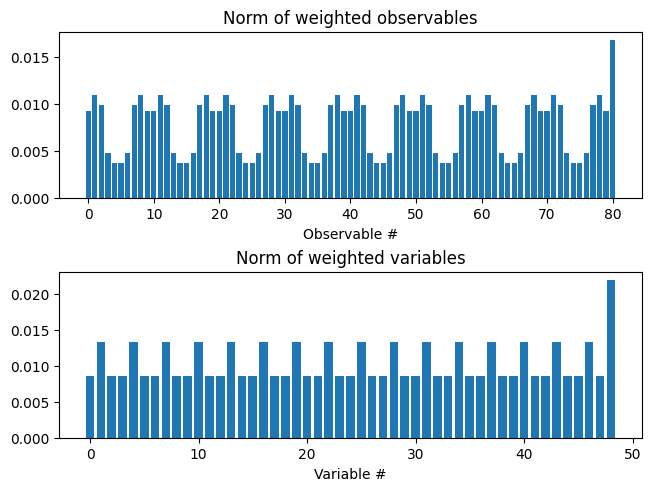

In [8]:
resp_h.plot_norm()

## Matrix pseudo-inversion

The {py:meth}`~.ResponseMatrix.solve` method computes the singular values of the
weighted response matrix and its pseudo-inverse.

In [9]:
resp_h.solve()

We can plot the singular values:

In [ ]:
resp_h.plot_singular_values()

After solving, orbit correction is available, for instance with

* {py:meth}`~.ResponseMatrix.correction_matrix` which returns the correction matrix (pseudo-inverse of
  the response matrix),
* {py:meth}`~.ResponseMatrix.get_correction` which returns a correction vector when given observed values,
* {py:meth}`~.ResponseMatrix.correct` which computes and optionally applies a correction
  for the provided {py:class}`.Lattice`.

## References